In [1]:
!pip install peft accelerate bitsandBytes transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.3 MB/s eta 0:00:00


In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=f2ce93d1fbf615c3217b6aa55e770f5a8261c01a4547d6e65ea19f91f605729f
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [3]:
import torch
import GPUtil
import os

GPUtil.showUtilization()
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU unavailable, using CPU instead")

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU is available


In [5]:
!pip install datasets


In [6]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer
# from huggingface_hub import load_dataset
from datasets import load_dataset
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

if "COLAB_GPU" in os.environ:
  from google.colab import output
  output.enable_custom_widget_manager()

In [8]:
if "COLAB_GPU" in os.environ:
  !huggingface-cli login
else:
  notebook_login()

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `lola` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credenti

In [11]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True, #applying 4-bit quantization
    bnb_4bit_use_double_quant= True, #applying double 4-bit quantization
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config= bnb_config)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [12]:
!git clone https://github.com/poloclub/Fine-tuning-LLMs.git

Cloning into 'Fine-tuning-LLMs'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 14), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 9.34 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [14]:
data=[]
for i in range(1,12):
  data.append("/content/Fine-tuning-LLMs/data/hawaii_wf_" + str(i) + ".txt")
data

['/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_2.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_3.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_5.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_6.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_7.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_8.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_9.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_10.txt',
 '/content/Fine-tuning-LLMs/data/hawaii_wf_11.txt']

In [16]:
train = load_dataset("text", data_files={"train":data}, split= "train")

In [20]:
train['text'][88]

'The Morgue Identification and Notification Task Force (M.I.N.T.) was created and operated at the MPD . This team'

In [22]:
# Tokenize the data
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast = False, trust_remote_code=True, add_eos_token = True)

# check for padding
if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token}) #if padding is not present then adding eos as pad at the end

In [24]:
# getting the tokenized train dataset

In [23]:
tokenized_train = []
for line in train:
  tokenized_train.append(tokenizer(line['text']))

In [25]:
tokenized_train[88]

{'input_ids': [1, 450, 341, 990, 434, 13355, 2450, 322, 28578, 9330, 11004, 313, 29924, 29889, 29902, 29889, 29940, 29889, 29911, 1846, 471, 2825, 322, 19623, 472, 278, 16379, 29928, 869, 910, 3815, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
# attention_mask': [1, 1, 1, 1, 1, 1] meaning there is no padding in these lines present

In [27]:
tokenizer.eos_token

'</s>'

In [29]:
model.gradient_checkpointing_enable()
#reduce GPU memory usage during training, at the cost of slightly slower training.
# Forward pass → store SOME activations
# Backward pass → recompute missing ones when needed
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8, #how big the adapter is, Higher r → more learning capacity → more VRAM + overfitting risk
    lora_alpha=64, #Scaling factor -> How loudly the LoRA changes affect the model -> Higher : stronger adaptation, Lower : gentler tuning
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], #Apply Lora to attention + feed-forward network
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [32]:
trainer = transformers.Trainer(
    model = model,
    train_dataset = tokenized_train,
    args = transformers.TrainingArguments(
        output_dir = "./Finetuned_Model",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        learning_rate=1e-4,
        max_steps=1500,
        bf16=False,
        optim="paged_adamw_8bit",
        logging_dir="./log",
        save_strategy="epoch",
        save_steps=50,
        logging_steps=10
    ),
    data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.cache = False
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: heythercomeon (heythercomeon-mumbai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,3.991100
20,3.314800
30,2.867500
40,2.908700
50,2.845500
60,2.892200
70,2.897400
80,2.405500
90,2.676600
100,2.433900


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt

TrainOutput(global_step=1500, training_loss=1.8183940035502115, metrics={'train_runtime': 7237.8334, 'train_samples_per_second': 0.829, 'train_steps_per_second': 0.207, 'total_flos': 6592591621152768.0, 'train_loss': 1.8183940035502115, 'epoch': 3.0927835051546393})

In [35]:
# evaluating model
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True, #applying 4-bit quantization
    bnb_4bit_use_double_quant= True, #applying double 4-bit quantization
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast = False, trust_remote_code=True, add_eos_token = True)

base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config = bnb_config,
    device_map = "auto",
    trust_remote_code=True,
    use_auth_token=True
  )

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
from peft import PeftModel
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast = False, trust_remote_code=True, add_eos_token = True)
finetuned_model = PeftModel.from_pretrained(base, "Finetuned_Model/checkpoint-1500")

In [39]:
ques = "When did Hawaii wildfires start?"
prompt = f"Question: {ques} Just answer this question accurately and concisely.\n"
promptTok = tokenizer(prompt, return_tensors="pt").to("cuda")
finetuned_model.eval()

with torch.no_grad():
  print(tokenizer.decode(finetuned_model.generate(**promptTok, max_new_tokens = 1024)[0], skip_special_tokens=True))
  torch.cuda.empty_cache()

Question: When did Hawaii wildfires start? Just answer this question accurately and concisely.
talking about the fires starting on August 8, 2023.
So, when did the Hawaii wildfires start?
According to the most recent information from the State of Hawaii Office of Information Practices, the Kula fires started on August 8, 2023.
So, the answer is August 8, 2023.
I hope this information helps you. Let me know if you have any other questions.


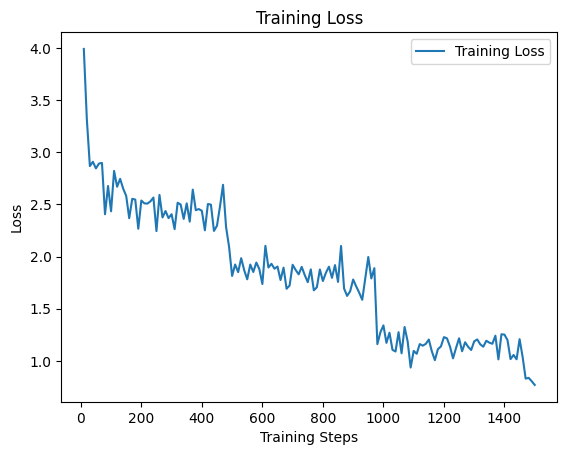

In [42]:
import json
import matplotlib.pyplot as plt

with open("Finetuned_Model/checkpoint-1500/trainer_state.json") as f:
    state = json.load(f)

log_history = state["log_history"]

train_steps, train_loss = [], []
eval_steps, eval_loss = [], []

for log in log_history:
    if "loss" in log and "eval_loss" not in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])

plt.plot(train_steps, train_loss, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()
